In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
directory = "two_point_correlation_results/"
name = "beadpack"

In [3]:
class Porestats(object):
    def __init__(self, data):
        self.name = data["name"]
        
        self.porosity = data["porosity"]
        self.porosity_sq = self.porosity*self.porosity
        
        #Covariance: C(x) = cov(x)+Vv^2
        self.covariance_x = np.array(data["x"])
        self.covariance_y =  np.array(data["y"])
        self.covariance_z =  np.array(data["z"])
        
        self.covariance_averaged = np.array(data["averaged"])
        
        #Covariance Function: cov(x) = C(x)-Vv^2
        self.covariance_function_x = self.covariance_x-self.porosity_sq
        self.covariance_function_y = self.covariance_y-self.porosity_sq
        self.covariance_function_z = self.covariance_z-self.porosity_sq
        
        self.covariance_function_averaged = self.covariance_averaged-self.porosity_sq
        
        #Normalized Covariance Function: cov(x)/(Vv-Vv^2)
        self.normalized_covariance_x = np.divide(self.covariance_function_x, self.porosity-self.porosity_sq)
        self.normalized_covariance_y = np.divide(self.covariance_function_y, self.porosity-self.porosity_sq)
        self.normalized_covariance_z = np.divide(self.covariance_function_z, self.porosity-self.porosity_sq)
        
        self.normalized_covariance_averaged = np.divide(self.covariance_function_averaged, self.porosity-self.porosity_sq)
        
        self.fit_x = None
        self.fit_y = None
        self.fit_z = None
        
        self.fit_averaged = None
        
        self.poly_x = None
        self.poly_y = None
        self.poly_z = None
        
        self.poly_averaged = None
        
        self.fit_poly()
        
    def fit_poly(self, N=5):
        self.fit_x = np.polyfit(range(len(self.covariance_x[0:N])), self.covariance_x[0:N], 1)
        self.poly_x = np.poly1d(self.fit_x)
        
        self.fit_y = np.polyfit(range(len(self.covariance_y[0:N])), self.covariance_y[0:N], 1)
        self.poly_y = np.poly1d(self.fit_y)
        
        self.fit_z = np.polyfit(range(len(self.covariance_z[0:N])), self.covariance_z[0:N], 1)
        self.poly_z = np.poly1d(self.fit_z)
        
        self.fit_averaged = np.polyfit(range(len(self.covariance_averaged[0:N])), self.covariance_averaged[0:N], 1)
        self.poly_averaged = np.poly1d(self.fit_averaged)
        
        self.rc_x = (self.porosity_sq-self.porosity)/self.poly_x[1]
        self.rc_y = (self.porosity_sq-self.porosity)/self.poly_y[1]
        self.rc_z = (self.porosity_sq-self.porosity)/self.poly_z[1]
        
        self.rc_averaged = (self.porosity_sq-self.porosity)/self.poly_averaged[1]

In [4]:
covariance_correlation_results = []
tpc_results = {}

porestats_objs = {}

for file in os.listdir(directory):
        if file.endswith(".json"):
            with open(directory+file) as data_file:
                data = json.load(data_file)
                covariance_correlation_results.append(data)
                tpc_results[data["name"]] = data
                porestats_objs[data["name"]] = Porestats(data)

In [16]:
pst = porestats_objs[name]
pst.fit_poly(N=10)

print pst.rc_x, pst.rc_y, pst.rc_z, pst.rc_averaged
print pst.poly_x[1]*-1*2e6
print (pst.porosity**3)/((1-pst.porosity)**2)*1./((pst.poly_x[1]*-1*2e6)**2)
print (pst.porosity**3)/((1-pst.porosity)**2)*1./((pst.poly_y[1]*-1*2e6)**2)
print (pst.porosity**3)/((1-pst.porosity)**2)*1./((pst.poly_z[1]*-1*2e6)**2)

15.1409734206 14.9874068484 14.9672524054 15.0314785477
30527.5527178
1.25847429401e-10
1.23307572612e-10
1.22976157781e-10


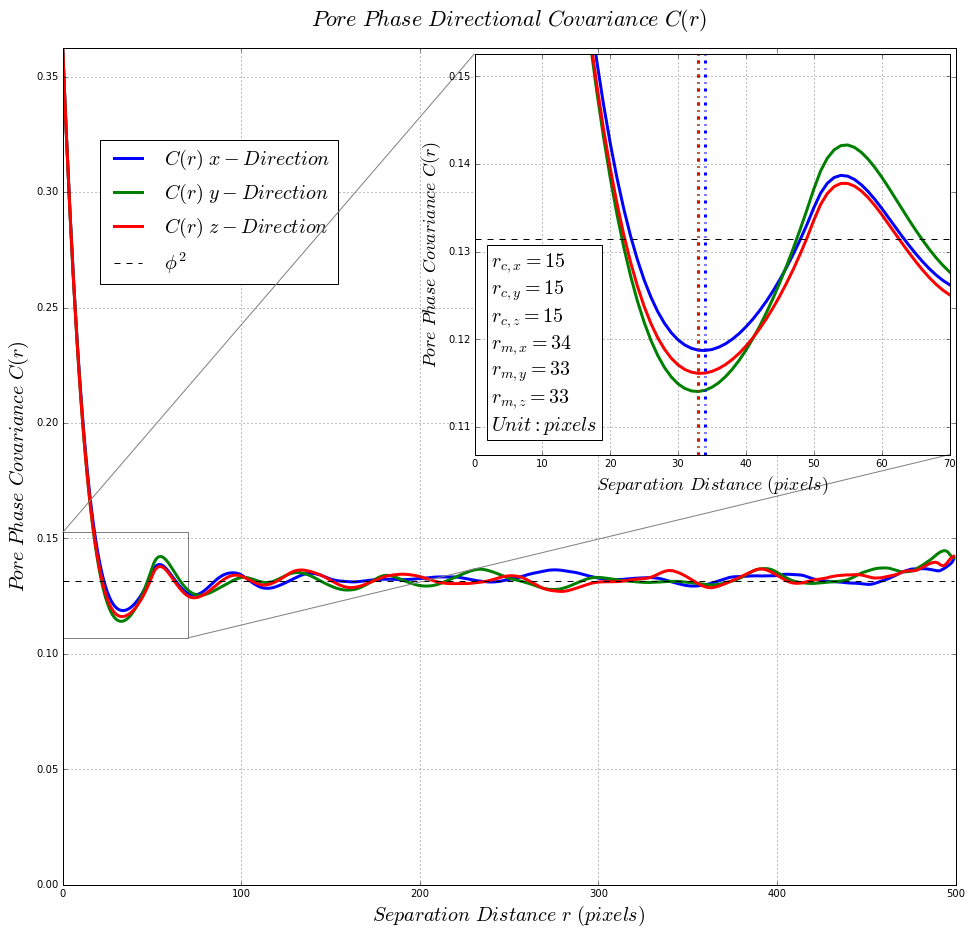

In [39]:
fig, ax = plt.subplots(figsize=(16,15))
axins = zoomed_inset_axes(ax, 3.8, loc=1) # zoom-factor: 2.5, location: upper-left

ax.grid()
ax.set_xlim(0, len(pst.covariance_x))
ax.set_ylim(0., max(pst.covariance_x))

ax.set_title(r'$Pore \ Phase \ Directional \ Covariance \ C(r)$', fontsize=22, y=1.02)

ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=20)
ax.set_ylabel(r'$Pore \ Phase \ Covariance \ C(r)$', fontsize=20)

x1, x2, y1, y2 = 0, 70, min(pst.covariance_x)*0.9, max(pst.covariance_x[50:200])*1.1
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.plot(range(len(pst.covariance_x)), pst.covariance_x, label=r'$C(r) \ x-Direction$', color="blue", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_y)), pst.covariance_y, label=r'$C(r)\ y-Direction$', color="green", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_z)), pst.covariance_z, label=r'$C(r) \ z-Direction$', color="red", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_x)), [pst.porosity_sq]*len(pst.covariance_x), color="black", linestyle="--", label=r'$\phi^2$')


axins.plot(range(len(pst.covariance_x)), pst.covariance_x, color="blue", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_y)), pst.covariance_y, color="green", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_z)), pst.covariance_z, color="red", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_x)), [pst.porosity_sq]*len(pst.covariance_x), color="black", linestyle="--", label=r'$\phi^2$')

rm_x = np.where(pst.covariance_x[0:200] == min(pst.covariance_x[0:200]))[0]
rm_y = np.where(pst.covariance_y[0:200] == min(pst.covariance_y[0:200]))[0]
rm_z = np.where(pst.covariance_z[0:200] == min(pst.covariance_z[0:200]))[0]

axins.axvline(rm_x, color="blue", alpha=1.0, linestyle="-.", linewidth=3)
axins.axvline(rm_y, color="green", alpha=1.0, linestyle="-.", linewidth=3)
axins.axvline(rm_z, color="red", alpha=1.0, linestyle="-.", linewidth=3)

axins.set_xlabel(r'$Separation \ Distance \ (pixels)$', fontsize=18)
axins.set_ylabel(r'$Pore \ Phase \ Covariance \ C(r)$', fontsize=18)

textstr = '$r_{c,x}=%.0f$\n$r_{c, y}=%.0f$\n$r_{c, z}=%.0f$\n$r_{m,x}=%.0f$\n$r_{m, y}=%.0f$\n$r_{m, z}=%.0f$\n$Unit: pixels$'%(pst.rc_x,pst.rc_y, pst.rc_z, rm_x, rm_y, rm_z)

props = dict(facecolor='white', alpha=1.0) #boxstyle='round', 

# place a text box in upper left in axes coords
text = axins.text(0.48, 0.76, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

start, end = axins.get_xlim()
axins.xaxis.set_ticks(np.arange(start, end+10, 10))

axins.grid()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,  bbox_to_anchor=(0., 0.8, 0.32, .102), fontsize=20)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

fig.savefig(directory+"/"+name+"/"+name+"_directional_covariance.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

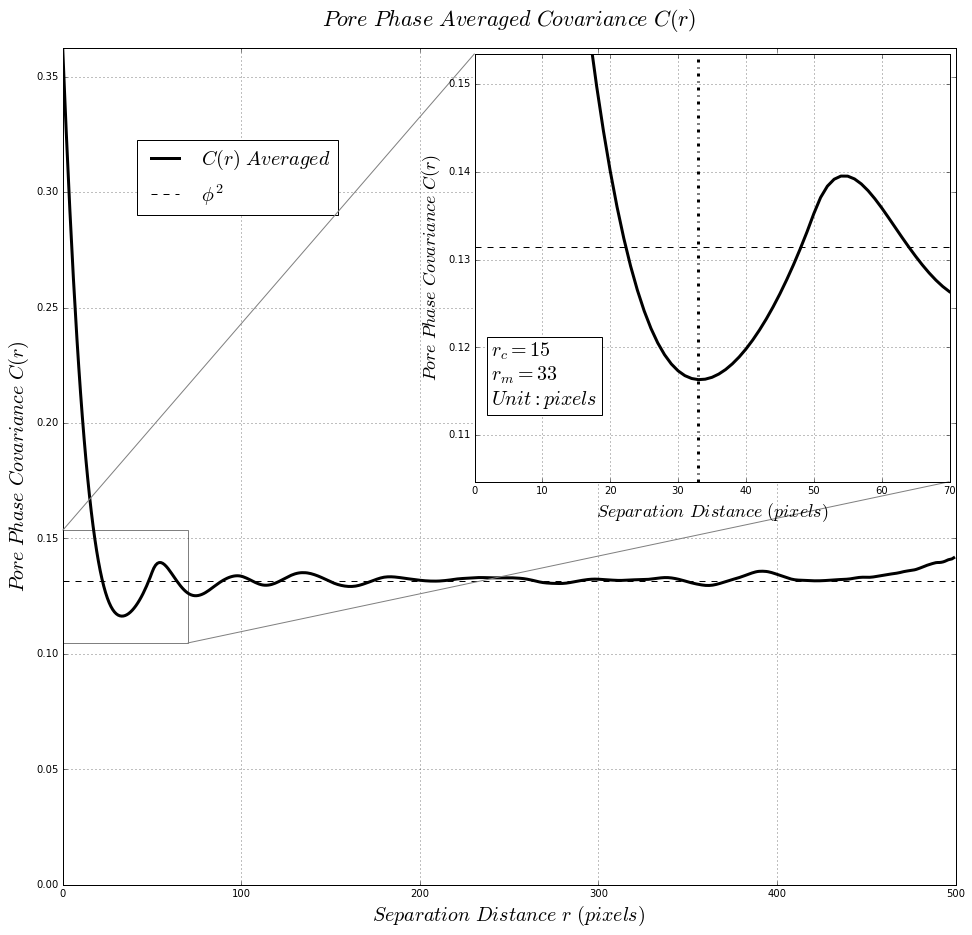

In [41]:
fig, ax = plt.subplots(figsize=(16,15))
axins = zoomed_inset_axes(ax, 3.8, loc=1) # zoom-factor: 2.5, location: upper-left

ax.grid()
ax.set_xlim(0, len(pst.covariance_x))
ax.set_ylim(0., max(pst.covariance_x))

ax.set_title(r'$Pore \ Phase \ Averaged \ Covariance \ C(r)$', fontsize=22, y=1.02)

ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=20)
ax.set_ylabel(r'$Pore \ Phase \ Covariance \ C(r)$', fontsize=20)

x1, x2, y1, y2 = 0, 70, min(pst.covariance_averaged)*0.9, max(pst.covariance_averaged[50:200])*1.1
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.plot(range(len(pst.covariance_averaged)), pst.covariance_averaged, label=r'$C(r) \ Averaged$', color="black", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_averaged)), [pst.porosity_sq]*len(pst.covariance_averaged), color="black", linestyle="--", label=r'$\phi^2$')


axins.plot(range(len(pst.covariance_averaged)), pst.covariance_averaged, color="black", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_averaged)), [pst.porosity_sq]*len(pst.covariance_averaged), color="black", linestyle="--", label=r'$\phi^2$')

rm_averaged = np.where(pst.covariance_averaged[0:200] == min(pst.covariance_averaged[0:200]))[0]

axins.axvline(rm_averaged, color="black", alpha=1.0, linestyle="-.", linewidth=3)

axins.set_xlabel(r'$Separation \ Distance \ (pixels)$', fontsize=18)
axins.set_ylabel(r'$Pore \ Phase \ Covariance \ C(r)$', fontsize=18)

textstr = '$r_{c}=%.0f$\n$r_{m}=%.0f$\n$Unit: pixels$'%(pst.rc_averaged, rm_averaged)

props = dict(facecolor='white', alpha=1.0) #boxstyle='round', 

# place a text box in upper left in axes coords
text = axins.text(0.48, 0.65, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

start, end = axins.get_xlim()
axins.xaxis.set_ticks(np.arange(start, end+10, 10))

axins.grid()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,  bbox_to_anchor=(0., 0.8, 0.32, .102), fontsize=20)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

fig.savefig(directory+"/"+name+"/"+name+"_averaged_covariance.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

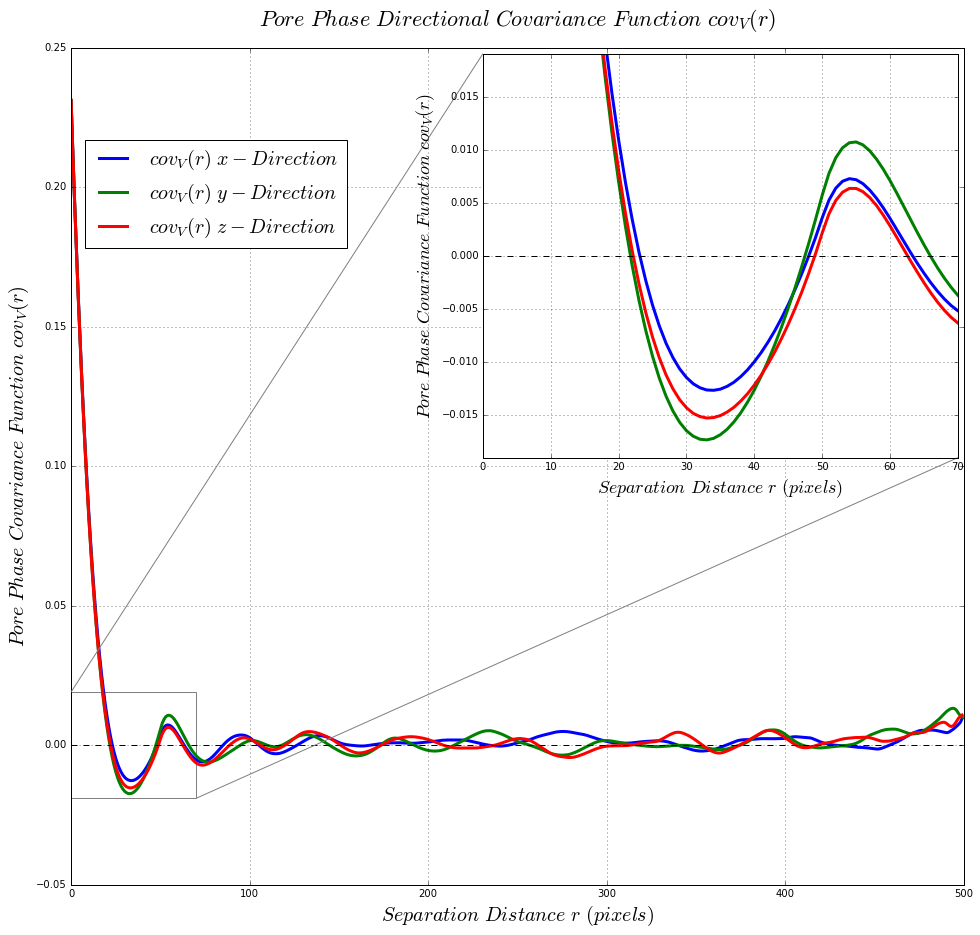

In [33]:
fig, ax = plt.subplots(figsize=(16,15))
axins = zoomed_inset_axes(ax, 3.8, loc=1) # zoom-factor: 2.5, location: upper-left

ax.grid()
ax.set_xlim(0, len(pst.covariance_function_x))

ax.set_title(r'$Pore \ Phase \ Directional \ Covariance \ Function \ cov_{V}(r)$', fontsize=22, y=1.02)

ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=20)
ax.set_ylabel(r'$Pore \ Phase \ Covariance \ Function \ cov_{V}(r)$', fontsize=20)

x1, x2, y1, y2 = 0, 70, min(pst.covariance_function_x)*1.5, min(pst.covariance_function_x)*-1.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.plot(range(len(pst.covariance_function_x)), pst.covariance_function_x, label=r'$cov_{V}(r) \ x-Direction$', color="blue", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_function_y)), pst.covariance_function_y, label=r'$cov_{V}(r) \ y-Direction$', color="green", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_function_z)), pst.covariance_function_z, label=r'$cov_{V}(r) \ z-Direction$', color="red", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_function_x)), [0.0]*len(pst.covariance_function_x), color="black", linestyle="--")

axins.plot(range(len(pst.covariance_function_x)), pst.covariance_function_x, color="blue", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_function_y)), pst.covariance_function_y, color="green", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_function_z)), pst.covariance_function_z, color="red", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_function_x)), [0.0]*len(pst.covariance_function_x), color="black", linestyle="--")

axins.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=18)
axins.set_ylabel(r'$Pore \ Phase \ Covariance \ Function \ cov_{V}(r)$', fontsize=18)

start, end = axins.get_xlim()
axins.xaxis.set_ticks(np.arange(start, end+10, 10))

axins.grid()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,  bbox_to_anchor=(0., 0.8, 0.32, .102), fontsize=20)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

fig.savefig(directory+"/"+name+"/"+name+"_directional_covariance_function.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

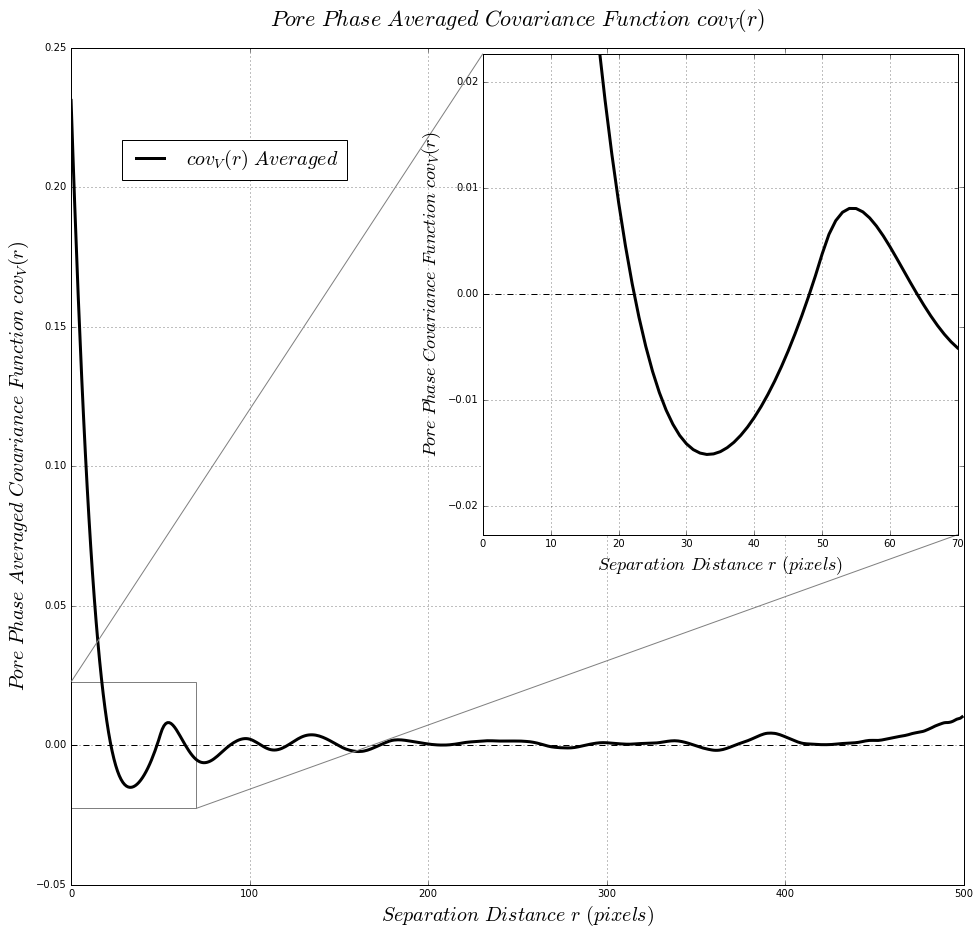

In [32]:
fig, ax = plt.subplots(figsize=(16,15))
axins = zoomed_inset_axes(ax, 3.8, loc=1) # zoom-factor: 2.5, location: upper-left

ax.grid()
ax.set_xlim(0, len(pst.covariance_function_averaged))

ax.set_title(r'$Pore \ Phase \ Averaged \ Covariance \ Function \ cov_{V}(r)$', fontsize=22, y=1.02)

ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=20)
ax.set_ylabel(r'$Pore \ Phase \ Averaged \ Covariance \ Function \ cov_{V}(r)$', fontsize=20)

x1, x2, y1, y2 = 0, 70, min(pst.covariance_function_averaged)*1.5, min(pst.covariance_function_averaged)*-1.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.plot(range(len(pst.covariance_function_averaged)), pst.covariance_function_averaged, label=r'$cov_{V}(r) \ Averaged$', color="black", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.covariance_function_averaged)), [0.0]*len(pst.covariance_function_averaged), color="black", linestyle="--")

axins.plot(range(len(pst.covariance_function_averaged)), pst.covariance_function_averaged, color="black", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.covariance_function_averaged)), [0.0]*len(pst.covariance_function_averaged), color="black", linestyle="--")

axins.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=18)
axins.set_ylabel(r'$Pore \ Phase \ Covariance \ Function \ cov_{V}(r)$', fontsize=18)


start, end = axins.get_xlim()
axins.xaxis.set_ticks(np.arange(start, end+10, 10))

axins.grid()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,  bbox_to_anchor=(0., 0.8, 0.32, .102), fontsize=20)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

fig.savefig(directory+"/"+name+"/"+name+"_averaged_covariance_function.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

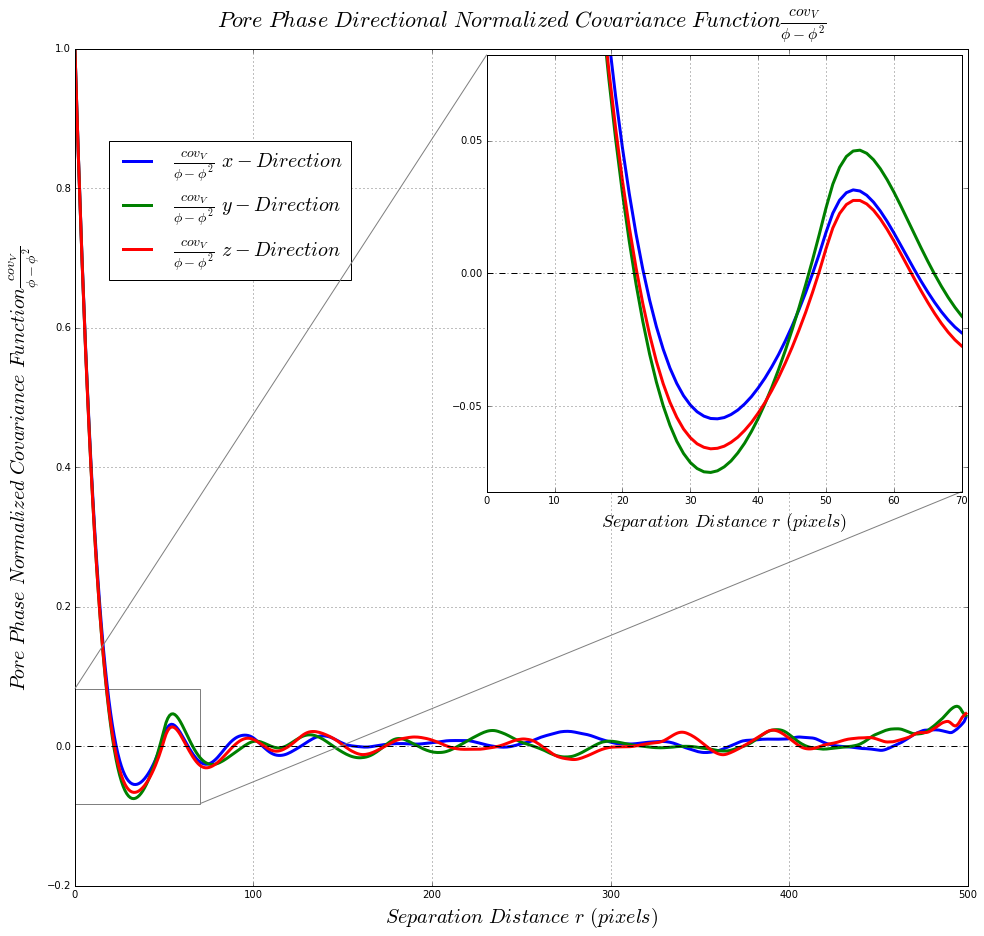

In [34]:
fig, ax = plt.subplots(figsize=(16,15))
axins = zoomed_inset_axes(ax, 3.8, loc=1) # zoom-factor: 2.5, location: upper-left

ax.grid()
ax.set_xlim(0, len(pst.normalized_covariance_x))

ax.set_title(r'$Pore \ Phase \ Directional \ Normalized \ Covariance \ Function \frac{cov_{V}}{\phi-\phi^2}$', fontsize=22, y=1.02)

ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=20)
ax.set_ylabel(r'$Pore \ Phase \ Normalized \ Covariance \ Function \frac{cov_{V}}{\phi-\phi^2}$', fontsize=20)

x1, x2, y1, y2 = 0, 70, min(pst.normalized_covariance_x)*1.5, min(pst.normalized_covariance_x)*-1.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.plot(range(len(pst.normalized_covariance_x)), pst.normalized_covariance_x, label=r'$\frac{cov_{V}}{\phi-\phi^2} \ x-Direction$', color="blue", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.normalized_covariance_y)), pst.normalized_covariance_y, label=r'$\frac{cov_{V}}{\phi-\phi^2} \ y-Direction$', color="green", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.normalized_covariance_z)), pst.normalized_covariance_z, label=r'$\frac{cov_{V}}{\phi-\phi^2} \ z-Direction$', color="red", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.normalized_covariance_x)), [0.0]*len(pst.normalized_covariance_x), color="black", linestyle="--")

axins.plot(range(len(pst.normalized_covariance_x)), pst.normalized_covariance_x, color="blue", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.normalized_covariance_y)), pst.normalized_covariance_y, color="green", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.normalized_covariance_z)), pst.normalized_covariance_z, color="red", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.normalized_covariance_x)), [0.0]*len(pst.normalized_covariance_x), color="black", linestyle="--")

axins.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=18)
#axins.set_ylabel(r'$Pore \ Phase \ Normalized \ Covariance \ Function \frac{cov_{V}}{\phi-\phi^2}$', fontsize=18)

start, end = axins.get_xlim()
axins.xaxis.set_ticks(np.arange(start, end+10, 10))

axins.grid()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,  bbox_to_anchor=(0., 0.8, 0.32, .102), fontsize=20)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

fig.savefig(directory+"/"+name+"/"+name+"_directional_normalized_covariance_function.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

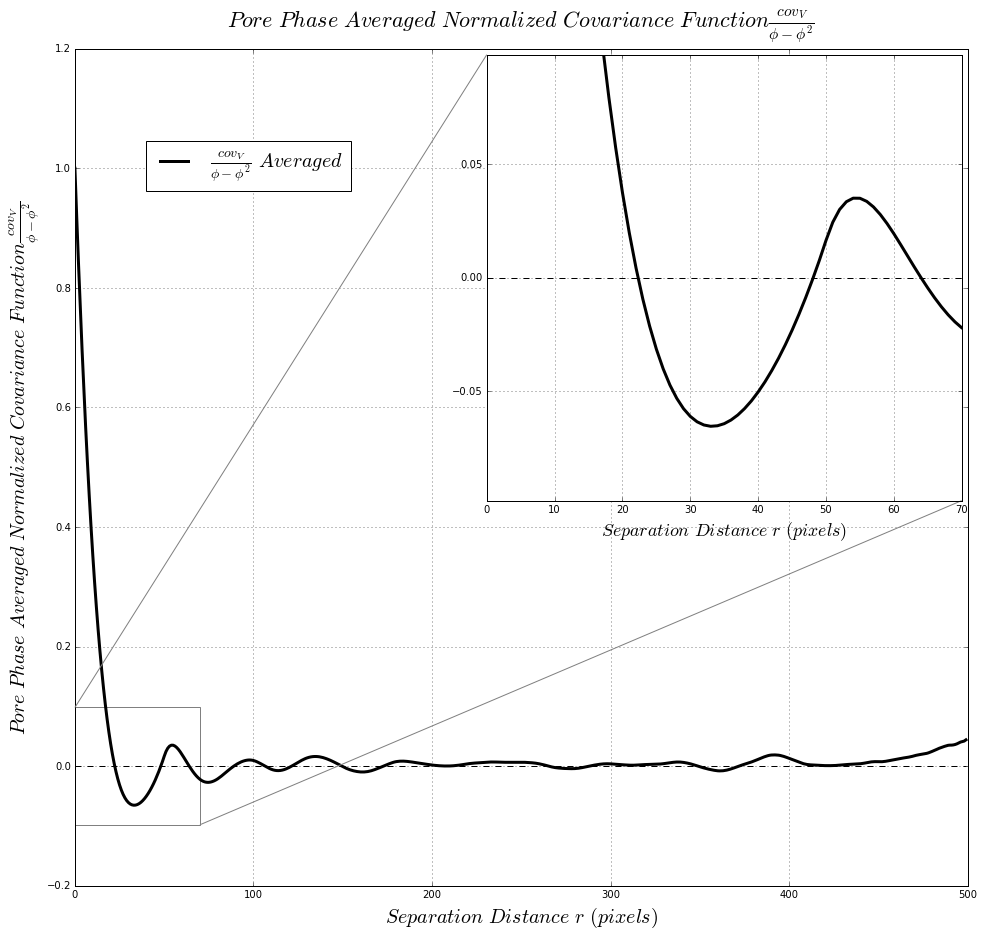

In [35]:
fig, ax = plt.subplots(figsize=(16,15))
axins = zoomed_inset_axes(ax, 3.8, loc=1) # zoom-factor: 2.5, location: upper-left

ax.grid()
ax.set_xlim(0, len(pst.normalized_covariance_averaged))

ax.set_title(r'$Pore \ Phase \ Averaged \ Normalized \ Covariance \ Function \frac{cov_{V}}{\phi-\phi^2}$', fontsize=22, y=1.02)

ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=20)
ax.set_ylabel(r'$Pore \ Phase \ Averaged \ Normalized \ Covariance \ Function \frac{cov_{V}}{\phi-\phi^2}$', fontsize=20)

x1, x2, y1, y2 = 0, 70, min(pst.normalized_covariance_averaged)*1.5, min(pst.normalized_covariance_averaged)*-1.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.plot(range(len(pst.normalized_covariance_averaged)), pst.normalized_covariance_averaged, label=r'$\frac{cov_{V}}{\phi-\phi^2} \ Averaged$', color="black", alpha=1.0, linestyle="-", linewidth=3)
ax.plot(range(len(pst.normalized_covariance_averaged)), [0.0]*len(pst.normalized_covariance_averaged), color="black", linestyle="--")

axins.plot(range(len(pst.normalized_covariance_averaged)), pst.normalized_covariance_averaged, color="black", alpha=1.0, linestyle="-", linewidth=3)
axins.plot(range(len(pst.normalized_covariance_averaged)), [0.0]*len(pst.normalized_covariance_averaged), color="black", linestyle="--")

axins.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=18)
#axins.set_ylabel(r'$Pore \ Phase \ Normalized \ Covariance \ Function \frac{cov_{V}}{\phi-\phi^2}$', fontsize=18)


start, end = axins.get_xlim()
axins.xaxis.set_ticks(np.arange(start, end+10, 10))

axins.grid()
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,  bbox_to_anchor=(0., 0.8, 0.32, .102), fontsize=20)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

fig.savefig(directory+"/"+name+"/"+name+"_averaged_normalized_covariance_function.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)